## Fast Word2vec

### Embedding 계층
**입력층의 원핫 표현과 가중치 행렬 W_in의 곱 계산**을 해결하기 위한 Embedding 계층에 대해서 알아보자  


**Embedding 계층에 대한 Model**  
<div><img src="https://user-images.githubusercontent.com/24144491/59848679-b60f0980-93a0-11e9-9d19-238ce3a8b238.png" height="250" width="600" /></div>
즉 저번 Post에서 설명한 W는 각 행이 각 단어의 분산 표현에 해당한다. 와 Input Data의 One-Hot-Encoding을 생각하여 Input Data를 W의 해당 단어의 분산 표현으로서 나타낸다는 의미 이다.  


위의 특징을 합쳐서 **Embedding 계층의 Forward는 결과적으로 단지 행렬(W)의 특정 행을 추출하는 방식으로 구현**할 수 있다.  


위와 같은 Forward를 구성하였으므로 **BackWard의 경우에도 해당하는 특정 행에만 기울기를 전달하고 나머지는 0으로서 구현하면 된다.**  


여기서 **Batch 처리**를 생각하게 되면 Backward의 경우 **같은 Index가 오는 경우에 값이 덮여씌워지는 현상**이 발생할 수 있기때문에 **더하기 연산으로 구현해야 한다.**   

In [1]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

**<span>W_out</span>의 곱 계산**을 어떻게 해결할 것인지를 생각해 보자.  
전체적인 아이디어는 위에서의 Embedding과 같다.  
저번 Post에서 설명한 **U는 W와 마찬가지로 각 행이 각 단어의 분산 표현에 해당한다.** 
Embedding과 마찬가지로 곱 계산을 하는 것이 아닌 **해당하는 행을 그저 가져오면 된다는 의미**이다.  
이렇게 가져온 행과 은닉층의 뉴런과의 내적으로 인하여 **<span>W_out</span>의 곱 계산**을 어떻게 해결할 수 있다.

In [2]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

**Backward**  
실질적인 Parameter를 사용하기 위해 LossFunction을 미분할 줄 알아야 한다.  
Loss Function을 CrossEntropy를 사용하고 Activation Function은 Sigmoid가 된다.  
Loss Function을 미분하는 과정은 아래와 같다.  
<p>$$y = \frac{1}{1+ exp(-x)}$$</p>
<p>$$\frac{\partial{y}}{\partial{x}} = y(1-y)$$</p>
<p>$$L = -(tlogy + (1-t)log(1-y))$$</p>
<p>$$\frac{\partial{L}}{\partial{x}} = -\frac{\partial{tlogy}}{\partial{x}} + \frac{\partial{tlog(1-t)log(1-y)}}{\partial{x}}$$</p>
<p>$$ = -t\frac{1}{y}y(1-y) + (1-t)\frac{1}{1-y}y(1-y)$$</p>
<p>$$= -t(1-y) + (1-t)y$$</p>
<p>$$= y-t$$</p>

위의 과정만으로 Loss를 측정해서 학습을 진행할 경우 Sigmoid의 Parameter라 긍정적인 예인 "say"에 대해서만 학습하게 된다.  

정확한 분류를 위해서는 긍정적인인 예 "say"에 대해서는 출력을 1에 가깝게 만들고 "say"외의 모든 단어에 대해서는 0 으로서 출력값이 나오게 학습을 하는것이 목표이다.  

**모든 부정적 예를 대상으로 이진 분류를 학습시키게 되면 연산량이 많아지므로 일부 부정적인 예를 통하여 학습하는 것**이 원래 목표였던 연산량을 줄이는 것에대한 적합한 방향이다.  
이러한 **적은 수의 분정적 예를 샘플링해 사용하는 것이 네거티브 샘플링** 기법이다.  
최종적인 Loss는 이러한 정답인 Loss와 네거티브 Loss의 합이 된다.  
위와 같이 **Sigmoid with Loss 계층**은 다음과 같이 구현 될 수 있다.  

In [3]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  #  # sigmoid의 출력
        self.t = None  # 정답 데이터

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx

**모든 부정적 예를 대상으로 이진 분류를 학습시키게 되면 연산량이 많아지므로 일부 부정적인 예를 통하여 학습하는 것**이 원래 목표였던 연산량을 줄이는 것에대한 적합한 방향이다.  
이러한 **적은 수의 분정적 예를 샘플링해 사용하는 것이 네거티브 샘플링** 기법이다.  
최종적인 Loss는 이러한 정답인 Loss와 네거티브 Loss의 합이 된다.  

**네거티브 샘플링의 샘플링 기법**  
네거티브 샘플링을 어떻게 샘플링을 할 것인지도 하나의 문제이다.  
자주 등장하는 단어를 많이 추출하고 드물게 등장하는 단어를 적게 추출하는 것이 Model의 성능을 좋게 만들 것이라는 것을 알 수 있다.(희소한 단어 자체는 나올 확률이 매우 적기 때문)  
이러한 과정은 각 **확률에 대해 0.75를 곱함으로 인하여 출현확률이 낮은 확률은 올리고 너무 높은 확률은 낮추는 방향**으로 진행하여 출현확률이 낮은 단어를 버리지 않는 방식으로 진행한다.  

**UnigramSampler**
- corpus: 말뭉치
- power: 각 확률에 곱할 인수
- sample_size: 샘플링을 수행할 횟수

**np.random.choice(words,size,replace,p)**
- words: 랜덤하게 뽑을 집합
- size: 샘플링할 size
- replace: False시 반복 X
- p: 각가의 Sampling될 확률

In [4]:
from common.config import GPU
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）로 계산할 때는 속도를 우선한다.
            # 부정적 예에 타깃이 포함될 수 있다.
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample

In [5]:
import numpy as np
import collections

corpus = np.array([0,1,2,3,4,1,2,3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus,power,sample_size)
target = np.array([1,3,0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[2 4]
 [0 4]
 [3 1]]


**최종적인 네거티브 Sampling with Loss 계층을 구현한 Code이다.**  

아래 코드는 다음과 같은 과정으로 진행된 것이다.  
1. **입력층의 원핫 표현과 가중치 행렬 W_in의 곱 계산**을 해결하기 위한 Embedding 계층
2. **<span>W_out</span>의 곱 계산** 을 해결하기 위한 EmbeddingDot 계층(입력 Embedding + HiddenLayer Embedding)
3. **BackPropagation**을 위한 **Sigmoid + CrossEntropy = Sigmoid With Loss 계층**
4.  네거티브 샘플링의 샘플링을 위한 UnigramSampler
5.  네거티브 샘플링 계층 NegativeSampleingLoss(Embedding Dot + UnigramSample + Sigmoid With Loss)

In [6]:
class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        #sample_size만큼 부정적인 예가 생김
        self.sampler = UnigramSampler(corpus, power, sample_size)
        #각 계층은 부정적인 예 + 1(긍정적인 예)의 Size를 가져야함
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        #각 매개변수와 기울기는 배열로서 저장
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

위의 최종적으로 얻은 네거티브 샘플링 계층을 활용하여 CBOW Model을 구현

In [7]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

CBOW Model Trainning

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 3001 / 9295 | 시간 183[s] | 손실 2.64
| 에폭 1 |  반복 6001 / 9295 | 시간 404[s] | 손실 2.38
| 에폭 1 |  반복 9001 / 9295 | 시간 632[s] | 손실 2.27
| 에폭 2 |  반복 1 / 9295 | 시간 654[s] | 손실 2.23
| 에폭 2 |  반복 3001 / 9295 | 시간 880[s] | 손실 2.15
| 에폭 2 |  반복 6001 / 9295 | 시간 1086[s] | 손실 2.09
| 에폭 2 |  반복 9001 / 9295 | 시간 1273[s] | 손실 2.04
| 에폭 3 |  반복 1 / 9295 | 시간 1294[s] | 손실 2.02
| 에폭 3 |  반복 3001 / 9295 | 시간 1514[s] | 손실 1.94
| 에폭 3 |  반복 6001 / 9295 | 시간 1735[s] | 손실 1.92
| 에폭 3 |  반복 9001 / 9295 | 시간 1955[s] | 손실 1.90
| 에폭 4 |  반복 1 / 9295 | 시간 1977[s] | 손실 1.89
| 에폭 4 |  반복 3001 / 9295 | 시간 2196[s] | 손실 1.82
| 에폭 4 |  반복 6001 / 9295 | 시간 2414[s] | 손실 1.81
| 에폭 4 |  반복 9001 / 9295 | 시간 2631[s] | 손실 1.80
| 에폭 5 |  반복 1 / 9295 | 시간 2653[s] | 손실 1.79
| 에폭 5 |  반복 3001 / 9295 | 시간 2874[s] | 손실 1.72
| 에폭 5 |  반복 6001 / 9295 | 시간 3092[s] | 손실 1.72
| 에폭 5 |  반복 9001 / 9295 | 시간 3309[s] | 손실 1.72
| 에폭 6 |  반복 1 / 9295 | 시간 3330[s] | 손실 1.72
| 에폭 6 |  반복 3001 

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text

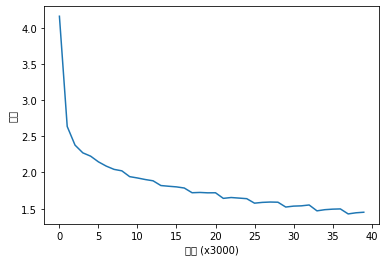

ModuleNotFoundError: No module named 'cupy'

In [9]:
# 학습을 위한 함수
import numpy
import time
import matplotlib.pyplot as plt
from common import config
import pickle
from common.util import clip_grads
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

# 하이퍼 파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 데이터 읽기 + target, contexts 만들기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)

# 모델 등 생성 - CBOW or SkipGram
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model,optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size, eval_interval = 3000) # eval_interval=500
trainer.plot()

In [10]:
# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

CBOW Model 평가

In [11]:
from common.util import most_similar, analogy

pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# 가장 비슷한(most similar) 단어 뽑기
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

# 유추(analogy) 작업
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[query] you
 we: 0.75439453125
 i: 0.70263671875
 your: 0.61083984375
 anything: 0.60498046875
 anybody: 0.6025390625

[query] year
 month: 0.86279296875
 week: 0.78125
 summer: 0.7744140625
 spring: 0.73291015625
 decade: 0.68310546875

[query] car
 truck: 0.62158203125
 window: 0.61328125
 cars: 0.5673828125
 auto: 0.55078125
 luxury: 0.5498046875

[query] toyota
 engines: 0.64501953125
 honda: 0.6103515625
 unocal: 0.60595703125
 ford: 0.60498046875
 seita: 0.60498046875
--------------------------------------------------

[analogy] king:man = queen:?
 woman: 5.5234375
 text: 5.01953125
 naczelnik: 4.7265625
 father: 4.671875
 a.m: 4.65625

[analogy] take:took = go:?
 came: 4.26171875
 began: 4.18359375
 went: 4.17578125
 're: 4.12109375
 eurodollars: 4.08984375

[analogy] car:cars = child:?
 a.m: 6.22265625
 rape: 5.60546875
 children: 5.5078125
 incest: 4.76171875
 woman: 4.62890625

[analogy] good:better = bad:?
 rather: 5.69140625
 more: 5.65625
 less: 5.27734375
 greater: 4.457